# Bounding box detection - Racoon data


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

### Import the necessary libraries

In [112]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Change directory

In [0]:
import os
os.chdir('/content/drive/My Drive/AIMLDataContent/R9ILab')

In [114]:
pwd

'/content/drive/My Drive/AIMLDataContent/R9ILab'

### Load the training data from train.csv file

In [0]:
import pandas as pd
df = pd.read_csv('./train_labels.csv')

In [116]:
df.head(5)

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290
3,raccoon-63.jpg,600,400,raccoon,227,93,403,298
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127


### Print the shape of the train dataset

In [117]:
df.shape

(173, 8)

In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173 entries, 0 to 172
Data columns (total 8 columns):
filename    173 non-null object
width       173 non-null int64
height      173 non-null int64
class       173 non-null object
xmin        173 non-null int64
ymin        173 non-null int64
xmax        173 non-null int64
ymax        173 non-null int64
dtypes: int64(6), object(2)
memory usage: 10.9+ KB


### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [0]:
IMAGE_SIZE = 128

### With the help of csv.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [0]:
# IMPORT LIBRARIES AND PACKAGES
import tensorflow as tf
import csv
import numpy as np
from PIL import Image
from keras import Model
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from keras.utils import Sequence
from keras.backend import epsilon

In [0]:
import csv
with open('./train_labels.csv', 'r') as csvfile:
    images = []
    coords = np.zeros((sum(1 for line in csvfile)-1, 4))
    reader = csv.reader(csvfile, delimiter=',')
    csvfile.seek(0)
    next(reader)
    for row,val in enumerate(reader):
      #print(row,val)               
      #for i, r in enumerate(val):  # Parse row with seven entities
          #print(i)
#          if((i!=0) & (i!=3)):
#            row[i] = int(r)
#            print(row)
          filename,image_width, image_height,classname, x0, y0, x1, y1 = val
          x0 = int(x0)
          y0 = int(y0)
          x1 = int(x1)
          y1 = int(y1)
          image_width = int(image_width)
          image_height = int(image_height)
#          print(x0)
          #print(image_width)
          filename = "./images_racoon/" + filename
          coords[row, 0] = x0 * IMAGE_SIZE / image_width # Normalize bounding box by image size
          coords[row, 1] = y0 * IMAGE_SIZE / image_height # Normalize bounding box by image size
          coords[row, 2] = (x1 - x0) * IMAGE_SIZE / image_width # Normalize bounding box by image size
          coords[row, 3] = (y1 - y0) * IMAGE_SIZE / image_height
          images.append(filename)           

In [122]:
len(images)

173

In [123]:
coords.shape

(173, 4)

### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [0]:
batch_images = np.zeros((len(images), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
for i, f in enumerate(images):
    img = Image.open(f) # Read image
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
    img = img.convert('RGB')
    batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))

In [125]:
len(batch_images)

173

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [0]:
img_depth = 3  

In [0]:
tf.keras.backend.clear_session()
model = tf.keras.applications.MobileNet(include_top=False, #Do not include FC layer at the end
                                        input_shape=(IMAGE_SIZE,IMAGE_SIZE, img_depth),
                                        weights='imagenet')

In [0]:
# to freeze layers, except the new top layer, of course, which will be added below
for layer in model.layers:
    layer.trainable = False

In [0]:
# Add new top layer which is a conv layer of the same size as the previous layer so that only 4 coords of BBox can be output
x = model.layers[-1].output
x = tf.keras.layers.Conv2D(4, kernel_size=4, name="coords")(x)
# In the line above kernel size should be 3 for img size 96, 4 for img size 128, 5 for img size 160 etc.
x = tf.keras.layers.Reshape((4,))(x) # These are the 4 predicted coordinates of one BBox

In [0]:
model = tf.keras.Model(inputs=model.input, outputs=x)

### Define a custom loss function IoU which calculates Intersection Over Union

In [0]:
gt = coords
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_func(loss, [y_true, y_pred], tf.float32)
    return iou

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [0]:
model.compile(optimizer='Adam', loss='mse', metrics=[IoU])

In [140]:
model.fit(batch_images,gt,
            epochs=10,batch_size = 32,
            verbose=1)

Train on 173 samples
Epoch 1/10
173/173 [==============================] - 6s 36ms/sample - loss: 2871.8905 - IoU: 0.0988
Epoch 2/10
173/173 [==============================] - 6s 32ms/sample - loss: 667.4752 - IoU: 0.4345
Epoch 3/10
173/173 [==============================] - 6s 32ms/sample - loss: 647.5665 - IoU: 0.5496
Epoch 4/10
173/173 [==============================] - 6s 33ms/sample - loss: 589.8563 - IoU: 0.5341
Epoch 5/10
173/173 [==============================] - 6s 32ms/sample - loss: 344.1015 - IoU: 0.5852
Epoch 6/10
173/173 [==============================] - 6s 33ms/sample - loss: 274.1794 - IoU: 0.5820
Epoch 7/10
173/173 [==============================] - 6s 32ms/sample - loss: 250.9414 - IoU: 0.6087
Epoch 8/10
173/173 [==============================] - 5s 31ms/sample - loss: 197.7046 - IoU: 0.6573
Epoch 9/10
173/173 [==============================] - 6s 32ms/sample - loss: 162.5621 - IoU: 0.7111
Epoch 10/10
173/173 [==============================] - 5s 32ms/sample - loss: 

### Pick a test image from the given data

In [0]:
import cv2
filename = './images_racoon/raccoon-1.jpg'
unscaled = cv2.imread(filename) # Original image for display

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [0]:
image_height, image_width, _ = unscaled.shape
image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE)) # Rescaled image to run the network
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

### Predict the coordinates of the bounding box for the given test image

In [0]:
region = model.predict(x=np.array([feat_scaled]))[0] # Predict the BBox

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

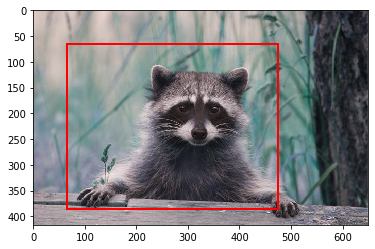

In [144]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)


import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np


# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

# Time Series Prediction using LSTM

### Download Data
Link: https://datamarket.com/data/set/2324/daily-minimum-temperatures-in-melbourne-australia-1981-1990#!ds=2324&display=line

#### Description
Daily minimum temperatures in Melbourne, Australia, 1981-1990

Units: Degrees Celcius

#### Steps before loading
- Rename the column name with temprature values to "Temprature"
- In the last, there is one extra row in the data, remove it by opening the file and save it again.
- There are some values in Temprature column which have a "?" before them, they will give error, remove "?" before them and save the file
- If you don't want to do these steps, just load the data file given by Great Learning.

#### Mount google drive

#### Change your present working directory

### Load your data file

#### Plot data

#### Descibe your dataframe

#### Check for null values

#### Drop null values

#### Get the representation of the distribution of data in the form of histogram

#### Check the maximum and minimum values

### Normalize the data

#### Check the maximum and minimum values of scaled data

#### Look into some of the scaled values

### Split data into Training and Testing

#### Print train and test size

## Create the sequential data
Map the temprature at a particular time t to the temprature at time t+n, where n is any number you define.

For example: to map tempratures of consecutive days, use t+1, i.e. loop_back = 1

#### Define your function to create dataset

#### Use function to get training and test set

#### Transform the prepared train and test input data into the expected structure using numpy.reshape()

## Define Model

### Define sequntial model, add LSTM layer and compile the model

### Summarize your model

### Train the model

## Make Predictions and Evaluate your model

## Plot the results